<h1><b>인공지능개론 6주차 과제<br></b></h1>
<p>컴퓨터공학과 202136038 조성준</p>


---

<h1><b>Pytorch 분류(abalone.csv)<br></b></h1>

---



<h2><b>0. 라이브러리 import(분류)</b></h2>

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# pytorch관련 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary

<h2><b>1. 데이터 로딩</b></h2>

In [98]:
# URL
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/abalone.csv"

# URL에서 직접 CSV 불러오기
df = pd.read_csv(url)

# 데이터 확인
df

,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...,...
4172,4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [99]:
# 컬렴명 확인
print(df.columns)

Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole_weight',
       'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')


<h2><b>2. 결측치 확인</b></h2>

In [100]:
# 결측치 확인
print(df.isnull().sum())
# 확인 결과: 결측치가 확인되지않음

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64


<h2><b>3. 레이블 확인(imbalanced data)</b></h2>
<li>타겟 변수의 분포를 확인</li>

,count
Sex,
M,1528
I,1342
F,1307


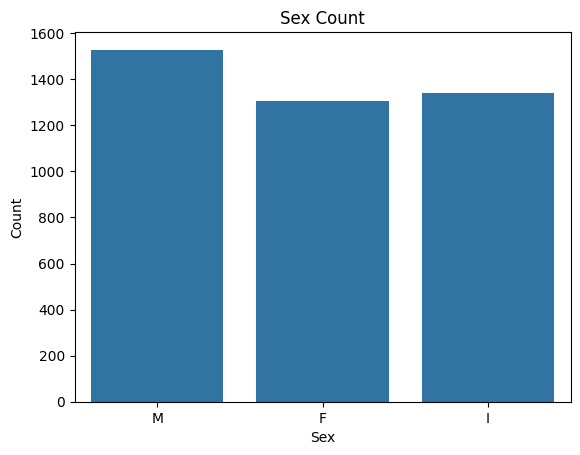

In [101]:
# 레이블 갯수 확인 (그래프)
sns.countplot(data=df, x="Sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.title("Sex Count")
# 레이블 갯수 확인 (숫자)
df['Sex'].value_counts()

<h2><b>4. 데이터 전처리</b></h2>

In [102]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# 타겟: Sex (F, M, I) → 정수로 변환
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])  # F=0, I=1, M=2
y = df['Sex'].values

# 입력값: id, Sex, Rings 제외
X = df.drop(['id', 'Sex', 'Rings'], axis=1).values

# 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 학습/검증 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Tensor로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

<h2><b>5. 모델 정의</b></h2>

In [103]:
class AbaloneClassifier(nn.Module):
    def __init__(self):
        super(AbaloneClassifier, self).__init__()
        self.fc1 = nn.Linear(7, 64)  # 수정됨
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

model = AbaloneClassifier()

<h2><b>6. 손실함수 및 옵티마이져 기법 정의</b></h2>

In [104]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

<h2><b>7. 모델 학습 </b></h2>

In [105]:
# 학습 파라미터 초기화
num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # 검증
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


Epoch 1/50, Train Loss: 0.9397, Val Loss: 0.8571, Val Acc: 0.5455
Epoch 2/50, Train Loss: 0.8935, Val Loss: 0.8581, Val Acc: 0.5443
Epoch 3/50, Train Loss: 0.8825, Val Loss: 0.8514, Val Acc: 0.5550
Epoch 4/50, Train Loss: 0.8800, Val Loss: 0.8435, Val Acc: 0.5670
Epoch 5/50, Train Loss: 0.8740, Val Loss: 0.8467, Val Acc: 0.5610
Epoch 6/50, Train Loss: 0.8712, Val Loss: 0.8493, Val Acc: 0.5622
Epoch 7/50, Train Loss: 0.8662, Val Loss: 0.8397, Val Acc: 0.5742
Epoch 8/50, Train Loss: 0.8606, Val Loss: 0.8662, Val Acc: 0.5670
Epoch 9/50, Train Loss: 0.8609, Val Loss: 0.8350, Val Acc: 0.5825
Epoch 10/50, Train Loss: 0.8583, Val Loss: 0.8385, Val Acc: 0.5789
Epoch 11/50, Train Loss: 0.8525, Val Loss: 0.8491, Val Acc: 0.5813
Epoch 12/50, Train Loss: 0.8493, Val Loss: 0.8362, Val Acc: 0.5849
Epoch 13/50, Train Loss: 0.8497, Val Loss: 0.8527, Val Acc: 0.5646
Epoch 14/50, Train Loss: 0.8477, Val Loss: 0.8367, Val Acc: 0.5801
Epoch 15/50, Train Loss: 0.8480, Val Loss: 0.8376, Val Acc: 0.5730
Epoc

<h2><b>8. 학습곡선 시각화 </b></h2>

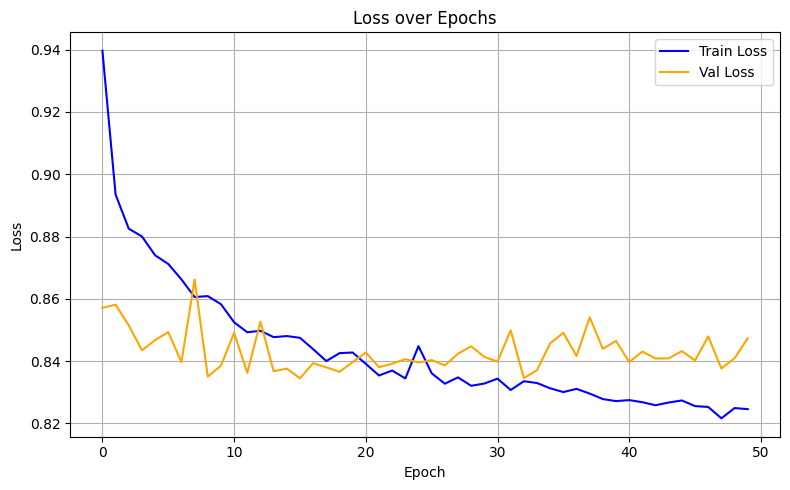

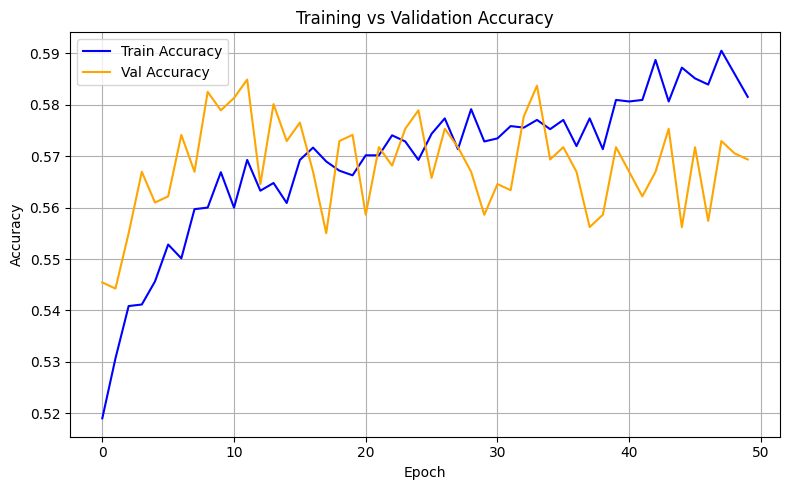

In [106]:
# Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Accuracy 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<h2><b>9. 모델 평가 </b></h2>

              precision    recall  f1-score   support

           F       0.48      0.39      0.43       262
           I       0.71      0.78      0.74       267
           M       0.50      0.54      0.52       307

    accuracy                           0.57       836
   macro avg       0.56      0.57      0.56       836
weighted avg       0.56      0.57      0.56       836



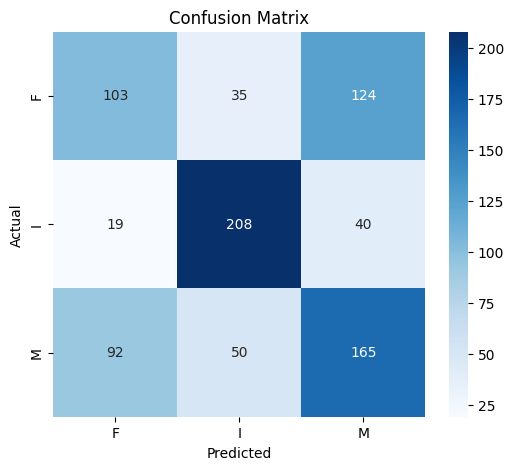

In [107]:
from sklearn.metrics import classification_report
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(y_batch.numpy())

# 리포트 출력
print(classification_report(all_labels, all_preds, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()